In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [4]:
players <- read_csv("players.csv")


session <- read_csv("sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


There is no duration of play which would be beneficial for analysis but easily computed. Additionally, the time in which the players log on may be from different time zones and this could alter when they think the most users are online. 

In [7]:
#number of observations and variables 
player_obs_and_vars<- dim(players)
player_vars_name_and_type <- tibble(
  variable = names(players),                    
  type = map_chr(players, typeof),                
  class = map_chr(players, ~ class(.x)[1]))

print(player_vars_name_and_type, max = nrow(player_vars_name_and_type))




# A tibble: 7 × 3
  variable     type      class    
  <chr>        <chr>     <chr>    
1 experience   character character
2 subscribe    logical   logical  
3 hashedEmail  character character
4 played_hours double    numeric  
5 name         character character
6 gender       character character
7 Age          double    numeric  


The above code shows that there are 196 observations in the player data set and 7 variables. The data set was analyzed and oragnized into a tibble showing the variable names, the type of variable and the class of variable. We can see the the variables experience, hashedEmail, name, and gender all share the same type and class of character. While the age variable is of type double and class numeric and the suscribe variable is of class and type logical. 

In [8]:
#What the variables mean 
variable_meaning<- list(
experience=  "A character variable that tells us the what the players abilities are regarding minecraft playing categorized as: Beginner, Regular, Amateur, Veteran and Pro .",  
suscribe =  "Tells us if a player is suscribed to the game related newsletter.", 
hashedEmail = "String of characters that represents the players email", 
played_hours = "The number of hours played for each player", 
name = "Tells us the username of the player.", 
gender= "Indicates the gender of the player.", 
Age= "Tells us the age of the player.") 
variable_meaning

$experience
[1] "A character variable that tells us the what the players abilities are regarding minecraft playing categorized as: Beginner, Regular, Amateur, Veteran and Pro ."

$suscribe
[1] "Tells us if a player is suscribed to the game related newsletter."

$hashedEmail
[1] "String of characters that represents the players email"

$played_hours
[1] "The number of hours played for each player"

$name
[1] "Tells us the username of the player."

$gender
[1] "Indicates the gender of the player."

$Age
[1] "Tells us the age of the player."

In [9]:
session_obs_and_vars<- dim(session)

session_vars_name_and_type<- tibble(variable = names(session), 
                                    type = map_chr(session, typeof), 
                                    class = map_chr(session, ~class(.x)[1]))
session_obs_and_vars
session_vars_name_and_type

[1] 1535    5

variable,type,class
<chr>,<chr>,<chr>
hashedEmail,character,character
start_time,character,character
end_time,character,character
original_start_time,double,numeric
original_end_time,double,numeric


The code above is the same as the first set of code but applied to the sessions data set. The data set has 1535 observations and 5 variables. The code organized the data variables into a tibble that shoes the type and class of each variable. The varaibles hashedEmail, start_time, and end_time are all of type and class character. While the variables original_start_time and original_end_time are of the type double and class numeric. 

In [10]:
#Sessions variables 
variables_meaning_sessions<- list(
    hashedEmail = "A string of characters that represents the players email", 
    start_time = "The date and time the session started.", 
    end_time = "The date and time the session ended.", 
    original_start_time = "The time the session started in the Unix timestamp format and is used for calculations.", 
    original_end_time = "The time the session ended in the Unix timestamp format and is used for calculations.")
variables_meaning_sessions

$hashedEmail
[1] "A string of characters that represents the players email"

$start_time
[1] "The date and time the session started."

$end_time
[1] "The date and time the session ended."

$original_start_time
[1] "The time the session started in the Unix timestamp format and is used for calculations."

$original_end_time
[1] "The time the session ended in the Unix timestamp format and is used for calculations."

In [11]:
mean_values_players<- players|> 
select(where(is.numeric))|>
summarise(across(everything(), mean, na.rm = TRUE))|>
pivot_longer(everything(),
               names_to = "Variable",
               values_to = "Mean")|> 
mutate(Mean= round(Mean, 2))

mean_values_players

Warning message:
“There was 1 warning in `summarise()`.
ℹ In argument: `across(everything(), mean, na.rm = TRUE)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


Variable,Mean
<chr>,<dbl>
played_hours,5.85
Age,21.14


In [12]:
mean_values_sessions<- session|> 
select(where(is.numeric))|> 
summarise(across(everything(), mean, na.rm = TRUE))|> 
pivot_longer(everything(), names_to = "Variable", 
             values_to = "Mean")|> 
mutate(Mean = round(Mean, 2))

print(mean_values_sessions, digits = 2)

# A tibble: 2 × 2
  Variable               Mean
  <chr>                 <dbl>
1 original_start_time 1.72e12
2 original_end_time   1.72e12


Can player experience and age predict the subscription to the game related newletter? 

The data in players.csv will help me address the question as it contains the variables age, experience and subscription information. The subscription variable is the response variable and gives a categorical answer. While experience and age is the predictive varaibles. By using the data to see if there is a linear relationship between experience/age and subscription I can see if I should use a linear regression model or a knn-classification model. 

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


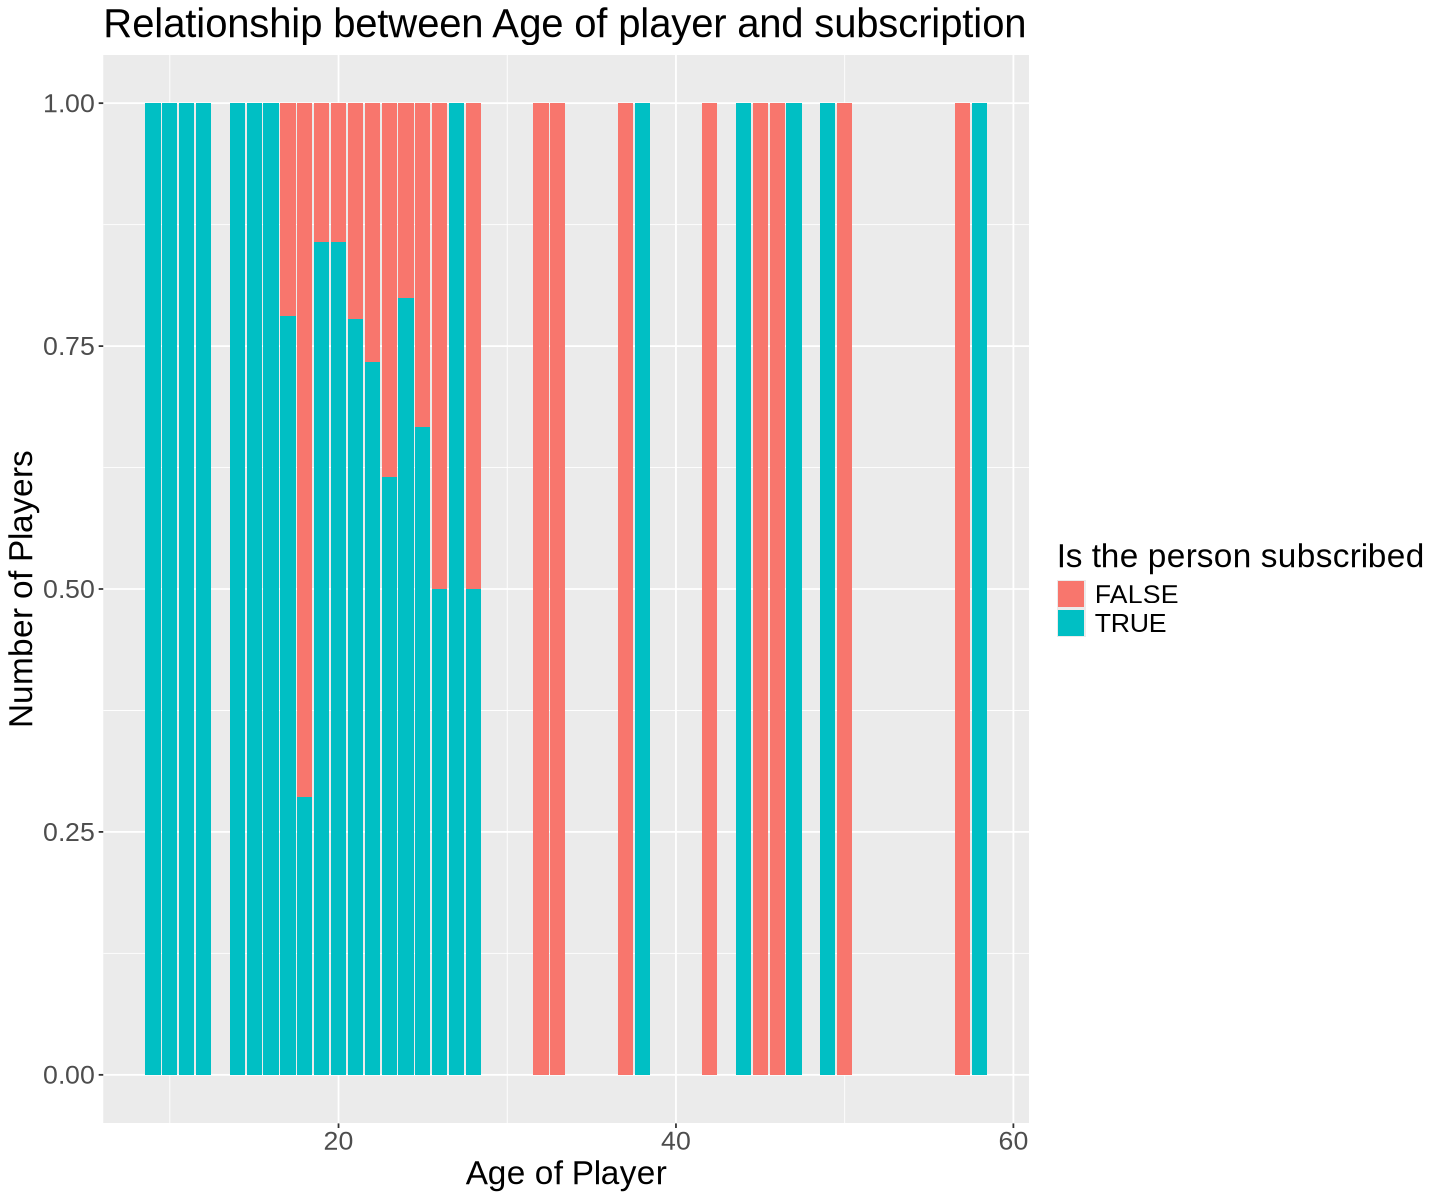

In [13]:
#Visulization of played_hours vs suscribe 
options(repr.plot.width = 12, repr.plot.height = 10)
plot_of_players<- players|> 
ggplot(aes(x = Age, fill = subscribe))+ 
geom_bar(position = 'fill')+ 
xlab("Age of Player") +
ylab("Number of Players")+
labs(fill = "Is the person subscribed")+ 
ggtitle("Relationship between Age of player and subscription")+
theme(text = element_text(size =20))


plot_of_players

The graph above shows the relationship between age and subscription. Since I am using a categorical value for response we have not been taught how to use this for scatter plots. Therefore using a bar graph and a more in depth analysis of the graph we can see that there is the possibility of a linear relationship between more younger people subscribing to the games related newsletter. However, this limited by a disproportionate amount of users for each age. 

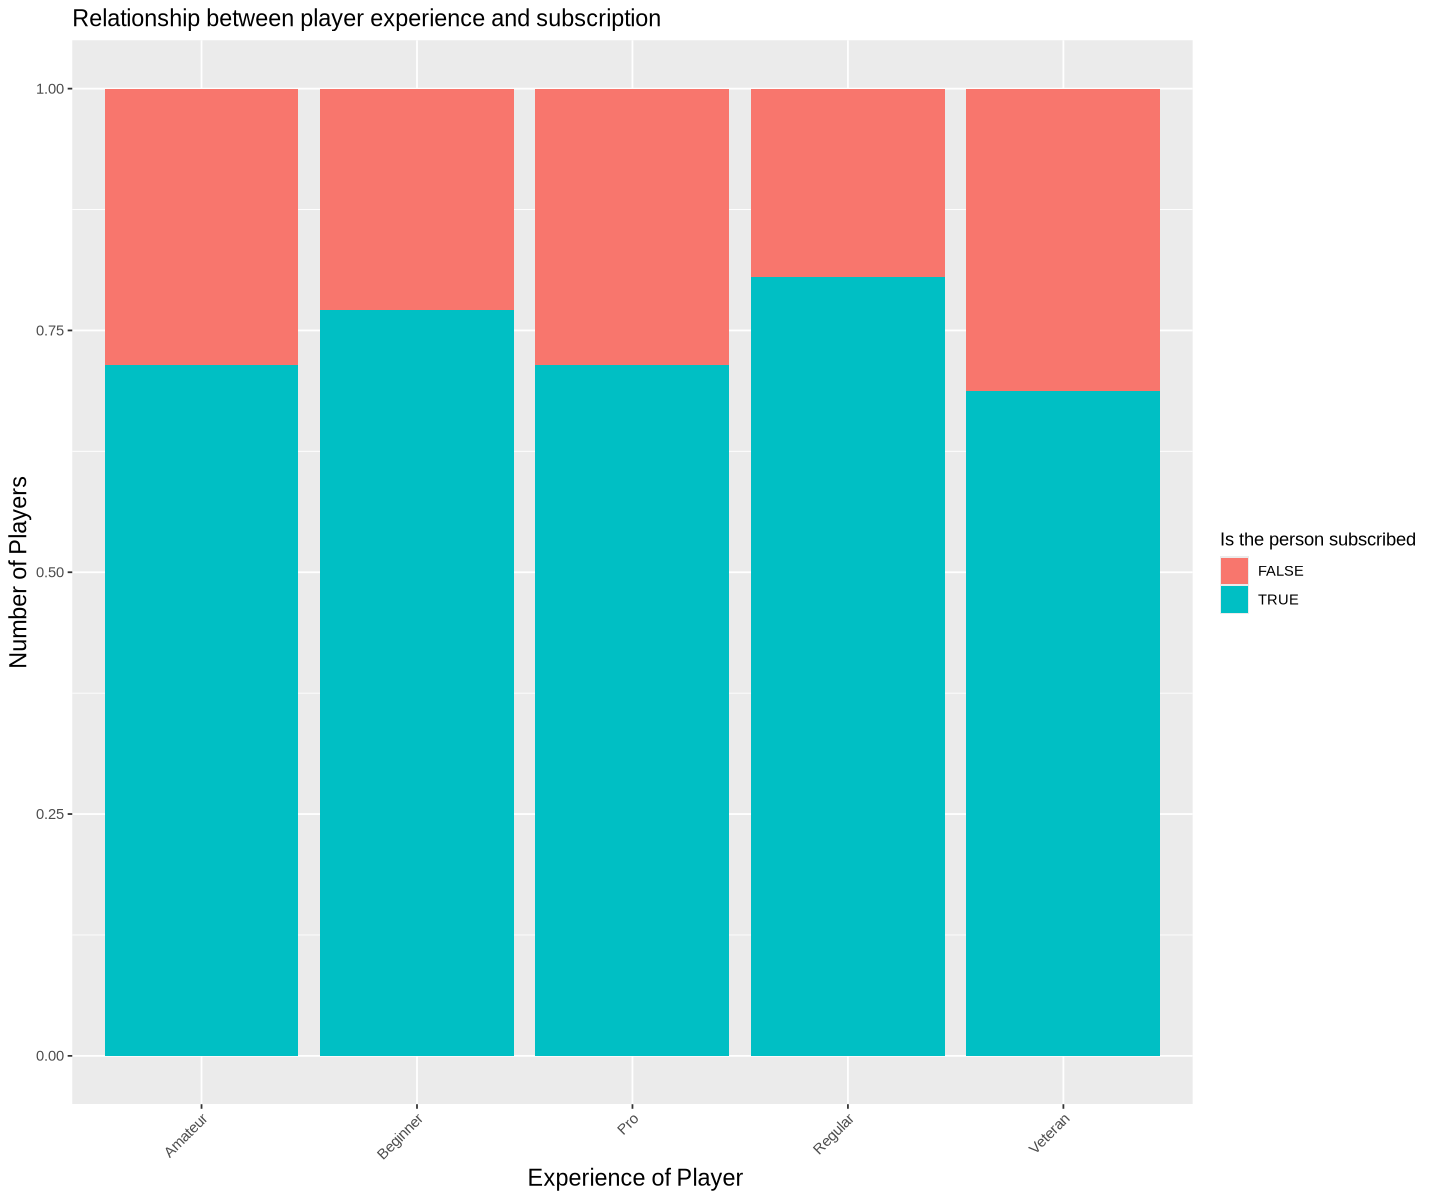

In [17]:
#visualization of experience vs suscribe 

graph_of_experience<- players|> 
ggplot(aes(x = experience, fill = subscribe))+ 
geom_bar(position = 'fill')+ 
xlab(" Experience of Player") +
ylab("Number of Players")+
labs(fill = "Is the person subscribed")+ 
ggtitle("Relationship between player experience and subscription")+
theme(plot.title = element_text(size = 14),
        axis.title = element_text(size = 14),
        axis.text.x = element_text(angle = 45, hjust = 1))
graph_of_experience




The graph above shows the relationship between experience of player and their likelihood to suscribe to the game related newsletter. Given the bar plot I would not same there is a clear linear relationship and therefore will not use linear regression to address my question 

In order to address my question I will use a k-nn classification model. I will do this as the two graphs above do not show clear linear relationships between the predictors and the response variable. Additionally, since my analysis of the data is limited by my knowledge of coding and not knowing how to incorporate a categorical variable into a scatter plot I will continue the analysis with k-nn prediction. This method is appropriate as I am asking a predictive question where I am looking to see how a predictive variable is related to the response variable. A potential limitation to this model is that if my data is actually linear the k-nn model is more susceptible to noise and may underfit or overfit the data. To further analyze which method is best I could train both models and determine the RMSE value and compare which one is lower. After determining with model has a lower RMSE value I could test using this model. In order to train the model I will split the data at the start into a 65/35 split and then use a 5 fold cross validation in order to optimize the selection of K. 